### 先训练一个基础的XGBoost模型，然后使用网格搜索调参。

In [50]:
import pandas as pd # type: ignore
# 显示所有列
pd.set_option('display.max_columns', None)
# # 显示所有行
pd.set_option('display.max_rows', None) 

In [51]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

#1. 加载数据
df = pd.read_csv('..\Data\data1.csv') # 请确保文件路径正确

#2. 数据预处理
X = df.drop('Y(1=default, 0=non-default)', axis=1) # 假设'Target'是目标变量
y = df['Y(1=default, 0=non-default)']

#处理类别变量
X = pd.get_dummies(X, drop_first=True)

#3. 数据标准化
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#4. 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

#5. 训练XGBoost模型
xgb = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
xgb.fit(X_train, y_train)

#6. 评估模型性能
y_pred_proba = xgb.predict_proba(X_test)[:, 1]
auc = roc_auc_score(y_test, y_pred_proba)
print(f"AUC: {auc}")

AUC: 0.8395239812477461


## 添加SMOTE对少数样本进行过采样，以解决正负样本不均衡问题

### 基于训练后模型评估的结果构建一个评分体系

In [52]:
# 7. 构建评分卡
def create_scorecard(model, feature_names, base_score=600, pdo=20, odds=50):
    # 获取特征重要性
    feature_importance = model.feature_importances_
    
    # 计算评分卡参数
    factor = pdo / np.log(2)
    offset = base_score - factor * np.log(odds)
    
    # 计算每个特征的得分
    scores = {}
    for feature, importance in zip(feature_names, feature_importance):
        score = round(offset + factor * np.log(importance + 1e-6))  # 加一个小数以避免log(0)
        scores[feature] = score
    
    return scores

# 创建评分卡
scorecard = create_scorecard(xgb, X.columns)

# 8. 计算信用得分
# 修改后的 calculate_credit_score 函数
def calculate_credit_score(X, scorecard):
    scores = np.zeros(X.shape[0])
    for feature, score in scorecard.items():
        if feature in X.columns:
            scores += X[feature].values * score
    return scores


# 在计算信用得分时，使用原始的 X（未标准化的数据）
credit_scores = calculate_credit_score(X, scorecard)

# 9. 将信用得分添加到原始数据框中
df['Credit_Score'] = credit_scores


### 评分卡可视化

d:\ProgramData\anaconda3\envs\pyTorchgpuEnv\Lib\site-packages\seaborn\_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


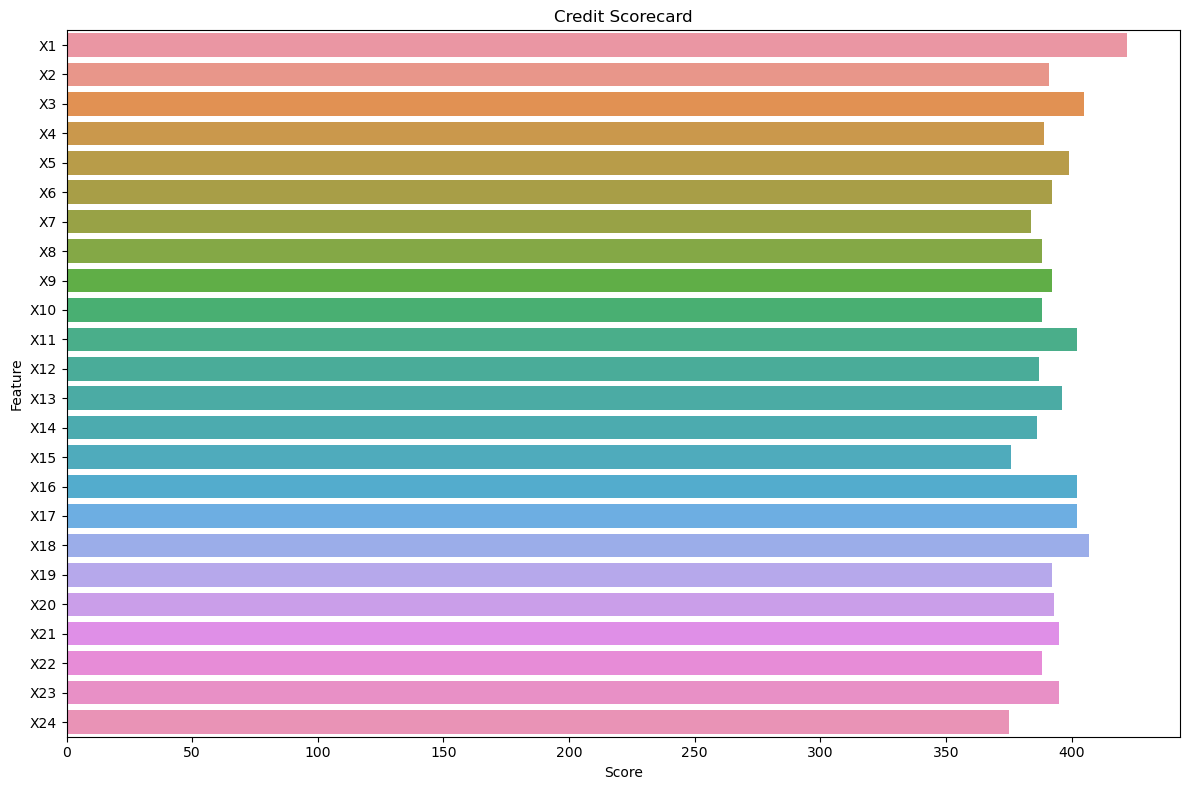

d:\ProgramData\anaconda3\envs\pyTorchgpuEnv\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


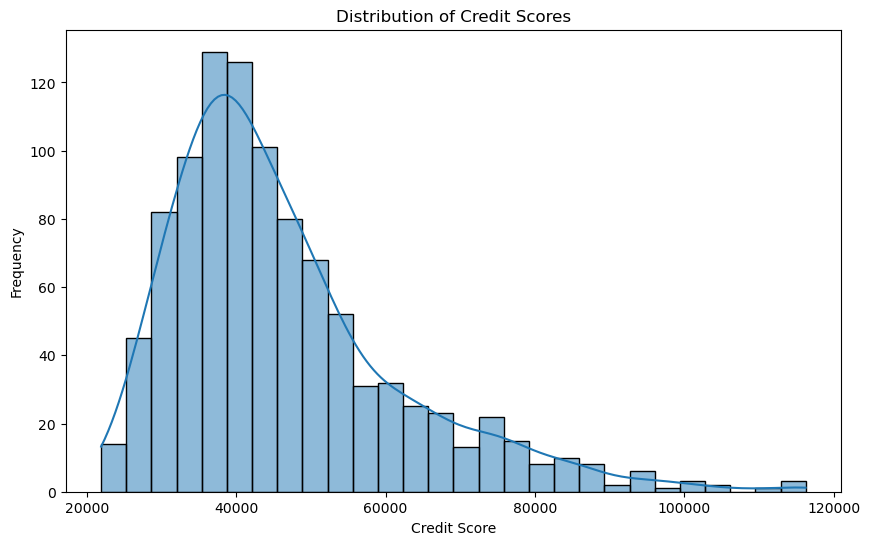

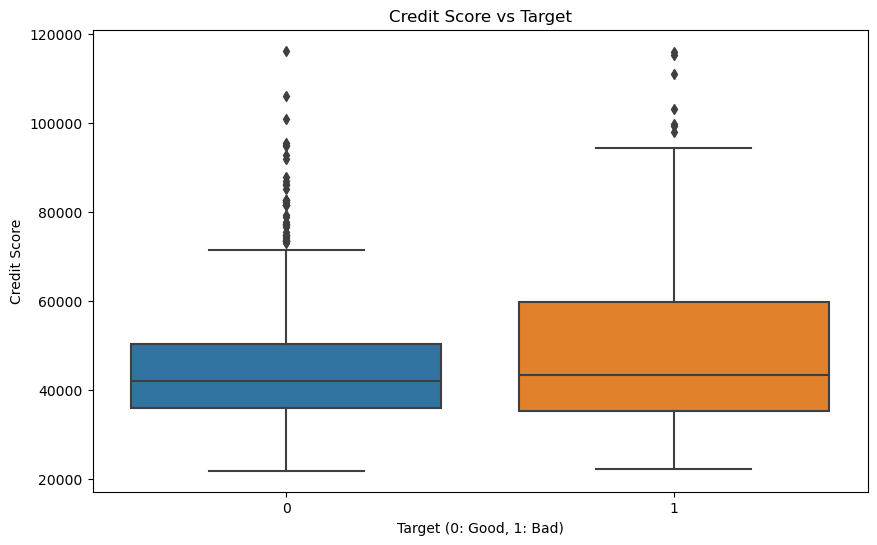

In [53]:

# 10. 可视化评分卡
plt.figure(figsize=(12, 8))
sns.barplot(x=list(scorecard.values()), y=list(scorecard.keys()))
plt.title('Credit Scorecard')
plt.xlabel('Score')
plt.ylabel('Feature')
plt.tight_layout()
# 保存图片
plt.savefig('../Data/Q2_credit_scorecard.png')
plt.show()

# 11. 可视化信用得分分布
plt.figure(figsize=(10, 6))
sns.histplot(df['Credit_Score'], kde=True)
plt.title('Distribution of Credit Scores')
plt.xlabel('Credit Score')
plt.ylabel('Frequency')
# 保存图片
plt.savefig('../Data/Q2_credit_score_distribution.png')
plt.show()

# 12. 信用得分与目标变量的关系
plt.figure(figsize=(10, 6))
sns.boxplot(x='Y(1=default, 0=non-default)', y='Credit_Score', data=df)
plt.title('Credit Score vs Target')
plt.xlabel('Target (0: Good, 1: Bad)')
plt.ylabel('Credit Score')
# 保存图片
plt.savefig('../Data/Q2_credit_score_vs_target.png')
plt.show()



### 得分保存到一个csv文件中方便后续问题直接调用

In [54]:
# 13. 打印信用得分的描述性统计
print("\nCredit Score Statistics:")
print(df['Credit_Score'].describe())

# 14. 保存结果
df.to_csv('../Data/Q2_german_credit_data_with_scores.csv', index=False)
print("\nResults saved to 'german_credit_data_with_scores.csv'")

# 15. 打印评分卡
print("\nScorecard:")
for feature, score in sorted(scorecard.items(), key=lambda x: x[1], reverse=True):
    print(f"{feature}: {score}")


Credit Score Statistics:
count      1000.000000
mean      46237.784000
std       15470.801948
min       21880.000000
25%       35599.750000
50%       42243.000000
75%       52713.250000
max      116263.000000
Name: Credit_Score, dtype: float64

Results saved to 'german_credit_data_with_scores.csv'

Scorecard:
X1: 422
X18: 407
X3: 405
X11: 402
X16: 402
X17: 402
X5: 399
X13: 396
X21: 395
X23: 395
X20: 393
X6: 392
X9: 392
X19: 392
X2: 391
X4: 389
X8: 388
X10: 388
X22: 388
X12: 387
X14: 386
X7: 384
X15: 376
X24: 375
